In [ ]:
!{sys.executable} -m conda install astropy

In [19]:
from utils import Candidate
from utils import Quadrant
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
import astropy.wcs as wcs

import psf
import crowdsource_base

from crowdsource_functions import utils

### Goal:
1. Do Dr. Knop's crowdsource on the reference image. Make sure the model and subtraction are much better.
2. Generate a reference csv file.
3. Based on the reference csv file, do Dr. Knop's crowdsource on another random image. Make sure the model and subtraction are much better.
4. Experiment with using gaussian vs. moffat psfs and toggling the refit_sky and other parameters on and off.

In [20]:
# Get the reference and test images

name = "DC21saaw"
radec = (270.31184, -28.77637)
c = Candidate(name, radec)
c.start()
iid = c.get_image_ids()
imref_fp, wref_fp = c.get_fp("c4d_210322_091756_ori") # Tuple of image and weight file
imfnames, wfnames = zip(*c.get_all_fps()) # List of tuples of image and weight files
c.close()

## Part 1: Crowdsource on a Reference Image

In [21]:
# Define tile parameters

s = 32 # Half the length of the picture in pixels
radec = (270.31177, -28.776405) # Given Ra/Dec to center on
radec = (270.31178, -28.77640) # Ra/Dec updated manually (why is it offset originally tho?)
imhdul = fits.open(imref_fp) # get an image reference file
weighthdul = fits.open(wref_fp) # get its weight reference file

In [22]:
# Create a quadrant and get image tile
q = Quadrant(imhdul, (2*s, 2*s)) # start a tile
subim, c = q.get_tile((radec[0], radec[1])) # Get the image centered on the int near radect
ymin, ymax, xmin, xmax = c #Boundaries of tile
weight = utils.get_weight(weighthdul, c) # Get the weight tile

In [23]:
# Run Crowdsource
psf_ = psf.gaussian_psf(4, deriv=False) # get the psf stamps
psf_ = np.reshape(psf_, (19, 19)) # reshape the psf into the shape the SimplePSF object needs.
psf__ = psf.SimplePSF(psf_) # make a SimplePSF psf object with the stamps.
    
#CROWDSOURCE GET XS AND YS
pars = crowdsource_base.fit_im(subim, psf__, weight=weight, 
                           verbose=True, miniter=4, maxiter=10, 
                           refit_psf=True, derivcentroids=True, refit_sky = False) # Get the crowdsource fit (including sky subtraction).

Extension None, iteration  1, found     35 sources;    0 close and    0 faint sources removed.
Extension None, iteration  2, found     16 sources;    0 close and    0 faint sources removed.
Fewer than 5 stars accepted in image, keeping original PSF
Extension None, iteration  3, found      2 sources;    0 close and    0 faint sources removed.
Fewer than 5 stars accepted in image, keeping original PSF
Extension None, iteration  4, found      0 sources;    0 close and    0 faint sources removed.


In [24]:
# Get the full positions (crowdsource positions go from 0 to 2*s)
xref, yref = utils.get_full_pos(pars, s, c)
radecs = utils.get_radecs(imhdul, xref, yref)

starting reference image


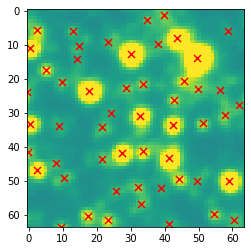

reference model image


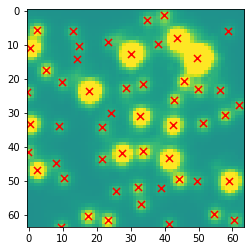

reference difference image


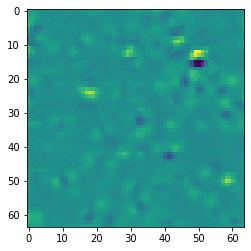

In [25]:
# Check everything by plotting
print("starting reference image")
plt.imshow(subim, vmin=-1600, vmax=1600 )
plt.scatter(pars[0]["y"], pars[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("reference model image")
plt.imshow(pars[1], vmin=-1600, vmax=1600 )
plt.scatter(pars[0]["y"], pars[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("reference difference image")
plt.imshow(subim - pars[1], vmin=-1600, vmax=1600 )
plt.show()

## Part 2: Forced Fit Crowdsource on an Arbitrary Image

In [30]:
def get_ts_row(imfname, wfname, csdict):
    try:
        imhdul = fits.open(imfname) # get a file
        weighthdul = fits.open(wfname)

        q = Quadrant(imhdul, (2*s, 2*s)) # start a tile
        subim, c = q.get_tile((radec[0], radec[1])) # Get the image centered on the int near radect
        ymin, ymax, xmin, xmax = c #Boundaries of tile
        weight = utils.get_weight(weighthdul, c) # Get the weight tile

        x, y = utils.get_xys(imhdul, radecs) # Get X/Y positions from ra/decs
        xref, yref = utils.get_rel_pos(x, y, s, c) # Get relative positions in terms of tile

        # Run Crowdsource Forced Fit
        psf_ = psf.gaussian_psf(4, deriv=False) # get the psf stamps
        psf_ = np.reshape(psf_, (19, 19)) # reshape the psf into the shape the SimplePSF object needs.
        psf__ = psf.SimplePSF(psf_) # make a SimplePSF psf object with the stamps.

        psf__ = psf.MoffatPSF(4, beta=3)

        #CROWDSOURCE GET XS AND YS
        pars_ = crowdsource_base.fit_im_force(subim, 
                                         yref, xref, 
                                         psf__, weight = weight, psfderiv = False, derivcentroids=False, refit_psf=True, refit_sky = True, startsky = 0) # Do the forced fit



        x = pars_[0]["y"]
        y = pars_[0]["x"]

        # Get Center Pos from Ra/Dec
        xy = q.get_xy_from_radec(np.array([[radec[0], radec[1]]])) # convert radec to pixel values
        xcenter = xy[0][0] - ymin
        ycenter = xy[0][1] - xmin

        xres = abs(x - xcenter)
        yres = abs(y - ycenter)

        totres = list(np.sqrt(xres**2 + yres**2))

        index = totres.index(min(totres))

        xpos = x[index]
        ypos = y[index]


        # Now get ra/dec, x, y, mjd, flux, dx, dy, and dflux for this
        mjd = imhdul[1].header["MJD-OBS"]
        ra = radec[0]
        dec = radec[1]
        flux = pars_[0]["flux"][index]
        dflux = pars_[0]["dflux"][index]
        dx = pars_[0]["dy"][index]
        dy = pars_[0]["dx"][index]

        csdict["MJD"].append(mjd)
        csdict["RA"].append(ra)
        csdict["DEC"].append(dec)
        csdict["flux"].append(flux)
        csdict["dflux"].append(dflux)
        csdict["x"].append(xpos)
        csdict["y"].append(ypos)
        csdict["dx"].append(dx)
        csdict["dy"].append(dy)
        csdict["sub stdv"].append(np.std(subim-pars[1]))

        return csdict
    
    except (OSError, FileNotFoundError) as e:
        return csdict

In [31]:
cs_dict = {"MJD":[], "RA":[], "DEC":[], "flux":[], "dflux":[], "x":[], "y":[], "dx":[], "dy":[], "sub stdv": []}
for i in range(len(imfnames)):
    cs = get_ts_row(imfnames[i], wfnames[i], cs_dict)
    
print(cs_dict)

Iteration 1, median sky   0.00
Fewer than 5 stars accepted in image, keeping original PSF
Iteration 2, median sky  22.04
Fewer than 5 stars accepted in image, keeping original PSF
Iteration 3, median sky  17.44
Fewer than 5 stars accepted in image, keeping original PSF
Iteration 4, median sky  13.86
Iteration 1, median sky   0.00
Fewer than 5 stars accepted in image, keeping original PSF
Iteration 2, median sky  44.69
Fewer than 5 stars accepted in image, keeping original PSF
Iteration 3, median sky  49.83
Fewer than 5 stars accepted in image, keeping original PSF
Iteration 4, median sky  53.69
Iteration 1, median sky   0.00
Iteration 2, median sky  28.86
Iteration 3, median sky  40.84
Iteration 4, median sky  57.97
Iteration 1, median sky   0.00
Fewer than 5 stars accepted in image, keeping original PSF
Iteration 2, median sky  19.68
Fewer than 5 stars accepted in image, keeping original PSF
Iteration 3, median sky  36.65
Fewer than 5 stars accepted in image, keeping original PSF
Iter

In [33]:
test_df = pd.DataFrame(cs_dict)
print(test_df)

               MJD         RA      DEC           flux        dflux          x  \
0     59295.384410  270.31178 -28.7764   85973.234375  3273.194092  32.397033   
1     59295.385860  270.31178 -28.7764  129424.812500  5374.859863  32.717733   
2     59295.386775  270.31178 -28.7764   95151.945312  4527.846680  32.822846   
3     59295.387456  270.31178 -28.7764   91161.890625  5078.495117  32.809824   
4     59295.388149  270.31178 -28.7764   88571.250000  3378.884277  32.742653   
...            ...        ...      ...            ...          ...        ...   
1307  59791.094708  270.31178 -28.7764   50053.632812  3274.749512  32.444530   
1308  59791.095393  270.31178 -28.7764   73972.242188  5075.336426  32.177439   
1309  59791.099103  270.31178 -28.7764   83124.421875  5164.242676  32.687166   
1310  59791.107077  270.31178 -28.7764   70128.015625  3993.054443  31.918269   
1311  59791.107745  270.31178 -28.7764   73985.960938  4981.417969  32.180689   

              y        dx  

In [34]:
test_df.to_csv("test.csv")

In [21]:
imhdul = fits.open(imfnames[2]) # get a file
weighthdul = fits.open(wfnames[2])

q = Quadrant(imhdul, (2*s, 2*s)) # start a tile
subim, c = q.get_tile((radec[0], radec[1])) # Get the image centered on the int near radect
ymin, ymax, xmin, xmax = c #Boundaries of tile
weight = utils.get_weight(weighthdul, c) # Get the weight tile

In [21]:
imhdul = fits.open(imfnames[2]) # get a file
weighthdul = fits.open(wfnames[2])

q = Quadrant(imhdul, (2*s, 2*s)) # start a tile
subim, c = q.get_tile((radec[0], radec[1])) # Get the image centered on the int near radect
ymin, ymax, xmin, xmax = c #Boundaries of tile
weight = utils.get_weight(weighthdul, c) # Get the weight tile

In [22]:
x, y = utils.get_xys(imhdul, radecs) # Get X/Y positions from ra/decs
xref, yref = utils.get_rel_pos(x, y, s, c) # Get relative positions in terms of tile

In [23]:
# Run Crowdsource Forced Fit
psf_ = psf.gaussian_psf(4, deriv=False) # get the psf stamps
psf_ = np.reshape(psf_, (19, 19)) # reshape the psf into the shape the SimplePSF object needs.
psf__ = psf.SimplePSF(psf_) # make a SimplePSF psf object with the stamps.

psf__ = psf.MoffatPSF(4, beta=3)
    
#CROWDSOURCE GET XS AND YS
pars_ = crowdsource_base.fit_im_force(subim, 
                                 yref, xref, 
                                 psf__, weight = weight, psfderiv = False, derivcentroids=False, refit_psf=True, refit_sky = True, startsky = 0) # Do the forced fit

Iteration 1, median sky   0.00
Iteration 2, median sky  28.86
Iteration 3, median sky  40.84
Iteration 4, median sky  57.97


starting reference image


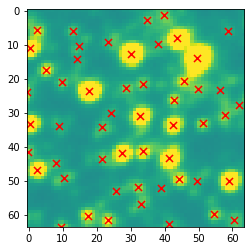

reference model image


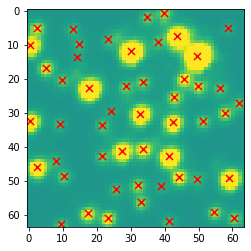

reference difference image


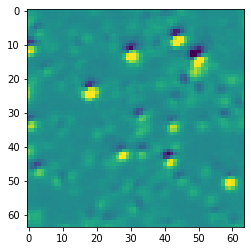

In [24]:
# Plot everything to make sure it looks ok
print("starting reference image")
plt.imshow(subim, vmin=-1600, vmax=1600 )
plt.scatter(pars[0]["y"], pars[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("reference model image")
plt.imshow(pars_[1], vmin=-1600, vmax=1600 )
plt.scatter(pars_[0]["y"], pars_[0]["x"], s=50, color = "red", alpha = 1, marker = "x")
plt.show()

print("reference difference image")
plt.imshow(subim - pars_[1], vmin=-1600, vmax=1600 )
plt.show()

In [25]:
# It does look ok!! (Finally)